In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Dense, Flatten, Input
from tensorflow.keras.layers import Dropout,Activation,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [3]:
print("Tensorflow Version:",tf.__version__)

Tensorflow Version: 2.4.1


In [4]:
print("GPU","available!!" if tf.config.list_physical_devices("GPU") else "not available!")

GPU available!!


In [7]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ekush-bangla/Ekush_Dataset/femaleCharacters.csv
/kaggle/input/ekush-bangla/Ekush_Dataset/maleCompunds1.csv
/kaggle/input/ekush-bangla/Ekush_Dataset/femaleModifiers.csv
/kaggle/input/ekush-bangla/Ekush_Dataset/maleCompunds2.csv
/kaggle/input/ekush-bangla/Ekush_Dataset/maleModifiers.csv
/kaggle/input/ekush-bangla/Ekush_Dataset/metaDataCSV.csv
/kaggle/input/ekush-bangla/Ekush_Dataset/maleDigits.csv
/kaggle/input/ekush-bangla/Ekush_Dataset/malechar1.csv
/kaggle/input/ekush-bangla/Ekush_Dataset/malechar2.csv
/kaggle/input/ekush-bangla/Ekush_Dataset/femaleCompound.csv
/kaggle/input/ekush-bangla/Ekush_Dataset/femaleDigits.csv
/kaggle/input/processed-data/data.npz


In [8]:
dataset_path = "/kaggle/input/ekush-bangla/Ekush_Dataset/"

# Prepare Data

In [9]:
#Load Data
train1 = pd.read_csv(dataset_path+"femaleCharacters.csv")
train2 = pd.read_csv(dataset_path+"femaleDigits.csv")
data = [train1, train2]

In [10]:
X,y = process_data(data)

Shape of X is (94240, 28, 28, 1)
Shape of y is (94240,)
Data type of X is <class 'numpy.ndarray'>
Data type of y is <class 'numpy.ndarray'>
took 0.7098867893218994 ms


In [10]:
X = process_image(X)

took 44.27620482444763 ms


# Visualizing Data

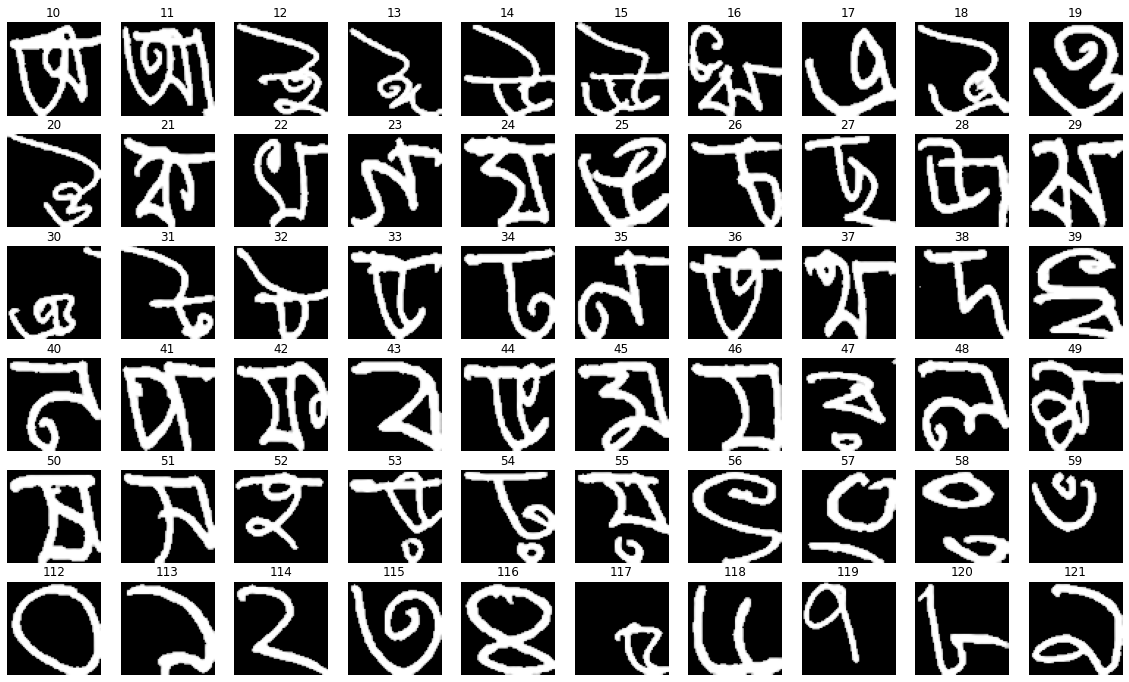

In [14]:
show_unique_images(X,y,0)

# Split Train and Validation Set

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.1, random_state = 42)

len(X_train),len(y_train),len(X_val),len(y_val)

(84816, 84816, 9424, 9424)

# One Hot Encoding

In [16]:
y_train = one_hot_encoding(y_train)
y_val = one_hot_encoding(y_val)
print(np.shape(y_train))
print(np.shape(y_val))

(84816, 60)
(9424, 60)


# Build, Complie & Train the Model

In [19]:
from tensorflow.keras.applications.mobilenet import MobileNet

MobileNet = MobileNet(weights='imagenet',include_top=False,input_shape=(224, 224,3))
MobileNet = change_model(MobileNet, new_input_shape=[None] + [64,64,3])

model = Sequential()

model.add(MobileNet)
model.add(Flatten())
model.add(Dense(60, activation='softmax'))

model.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 2, 2, 1024)        3228864   
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 60)                245820    
Total params: 3,474,684
Trainable params: 3,452,796
Non-trainable params: 21,888
_________________________________________________________________


In [20]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [21]:
history = model.fit(X_train,y_train, validation_data=(X_val, y_val), batch_size=32, epochs=10)

Epoch 1/10
2651/2651 [==============================] - 48s 16ms/step - loss: 1.0719 - accuracy: 0.7743 - val_loss: 0.3050 - val_accuracy: 0.9202
Epoch 2/10
2651/2651 [==============================] - 41s 15ms/step - loss: 0.2639 - accuracy: 0.9315 - val_loss: 0.2540 - val_accuracy: 0.9393
Epoch 3/10
2651/2651 [==============================] - 41s 15ms/step - loss: 0.1983 - accuracy: 0.9480 - val_loss: 0.1710 - val_accuracy: 0.9571
Epoch 4/10
2651/2651 [==============================] - 41s 16ms/step - loss: 0.1551 - accuracy: 0.9594 - val_loss: 0.1765 - val_accuracy: 0.9566
Epoch 5/10
2651/2651 [==============================] - 41s 16ms/step - loss: 0.1293 - accuracy: 0.9650 - val_loss: 0.1684 - val_accuracy: 0.9581
Epoch 6/10
2651/2651 [==============================] - 41s 16ms/step - loss: 0.1102 - accuracy: 0.9701 - val_loss: 0.1569 - val_accuracy: 0.9626
Epoch 7/10
2651/2651 [==============================] - 41s 16ms/step - loss: 0.0938 - accuracy: 0.9743 - val_loss: 0.1425 -

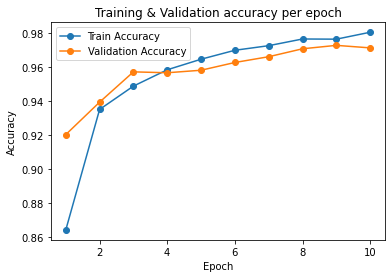

In [22]:
plot_accuracy(history)

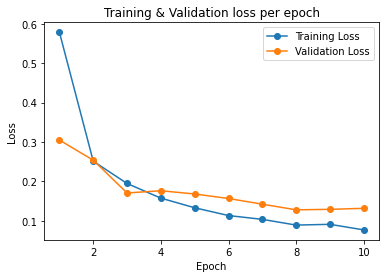

In [23]:
plot_loss(history)

# Save the Model

In [27]:
model_dir = "/kaggle/working/"
prefix = "FineTunedMobileNet"
model_path = save_model(model, model_dir, prefix, time=False)
print(model_path)

Saving model to: /kaggle/working/FineTunedMobileNet.h5...
/kaggle/working/FineTunedMobileNet.h5


# Utils

In [2]:
from tensorflow.keras.models import load_model
from PIL import Image, ImageChops,ImageOps
from datetime import datetime, timezone
from scipy import ndimage
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
import time
import pytz
import os


##############################################################################

def gray2rgb(gray):
    rgb = np.stack((gray,)*3, axis=-1)
    return rgb


def resize(img,size):
    img = Image.fromarray(img)
    resized_img = img.resize(size, Image.ANTIALIAS)
    resized_img_array = np.asarray(resized_img)
    return resized_img_array


def reshape(img,shape):
    img = np.reshape(img,shape)
    return img


def min_max_scalar(img, scale_range =(0, 1)):
    
    px_min = scale_range[0]
    px_max = scale_range[1]
    img = img.astype('float32')
    img = img/img.max()
    scaled_img = img * (px_max - px_min) + px_min
    return scaled_img



def improve_image_quality(img, n = 5):
    
    for i in range(n):
        mask = np.logical_and(img>0.0, img<0.2)
        img[mask] = 0.0
        img = img + 0.1
        img[img>1.0] = 1.0
        img[img==0.1] = 0.0
        
    return img

###########################################################################################

def performance(fn):
    def wrapper(*args,**kwargs):
        t1=time.time()
        result=fn(*args,**kwargs)
        t2=time.time()
        print(f'took {t2-t1} ms')
        return result
    return wrapper

############################################################################################

@performance
def process_image(image_array):
    
    processed_image = []
    
    for img in image_array:
        img = reshape(img,(28,28))
        img = resize(img,(64,64))
        img = gray2rgb(img)
        img = min_max_scalar(img)
        img = improve_image_quality(img,n=3)
        img = img.astype('float32')
        processed_image.append(img)
    
    processed_image = np.asarray(processed_image)
                               
    return processed_image

@performance
def process_data(data):
    data = pd.concat(data)
    y = data["label"]
    y = np.asarray(y)
    X = data.drop(labels = ["label"],axis = 1)
    X = X / 255.0
    X = X.values.reshape(-1,28,28,1)
    print(f"Shape of X is {X.shape}")
    print(f"Shape of y is {y.shape}")
    print(f"Data type of X is {type(X)}")
    print(f"Data type of y is {type(y)}")
    return X , y

####################################################################################


def unique_id(unique,idx=0):
    index=[]
    for i in unique:
        r = np.where(y==i)
        index.append (r[0][idx])
    return index 


def show_unique_images(X,y,idx=0):
    
    unique = np.unique(y)
    index = unique_id(unique,idx)
    
    images=[]
    labels=[]
    for i in index:
        images.append(X[i])
        labels.append(y[i])
    
    labels = list(labels)
    
    plt.figure(figsize=(20,12))
    
    for i in range(60):
        ax = plt.subplot(6,10, i+1)
        
        plt.imshow(images[i],cmap='gray')
        plt.title(labels[i])
        plt.axis("off")
        
    return None


#####################################################################


def one_hot_encoding(array):
    encoded_array = []
    unique = np.unique(array)
    for item in array:
        encoded_item = item == unique
        encoded_array.append(encoded_item)
    encoded_array = np.asarray(encoded_array)
    encoded_array = encoded_array.astype(int)
    return encoded_array


def change_model(model, new_input_shape=(None, 40, 40, 3),custom_objects=None):
    
    config = model.layers[0].get_config()
    config['batch_input_shape']=new_input_shape
    model._layers[0]=model.layers[0].from_config(config)

    new_model = tf.keras.models.model_from_json(model.to_json(),custom_objects=custom_objects)

    for layer in new_model._layers:
        try:
            layer.set_weights(model.get_layer(name=layer.name).get_weights())
            #print("Loaded layer {}".format(layer.name))
        except:
            print("Could not transfer weights for layer {}".format(layer.name))

    return new_model


#################################################################################################


def plot_accuracy(history):
    f,ax = plt.subplots()
    ax.plot([None]+history.history['accuracy'],'o-')
    ax.plot([None]+history.history['val_accuracy'],'o-')
    ax.legend(['Train Accuracy','Validation Accuracy'],loc = 0)
    ax.set_title('Training & Validation accuracy per epoch')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    return None


def plot_loss(history):
    f,ax = plt.subplots()
    ax.plot([None]+history.history['loss'],'o-')
    ax.plot([None]+history.history['val_loss'],'o-')
    ax.legend(['Training Loss','Validation Loss'],loc = 0)
    ax.set_title('Training & Validation loss per epoch')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    return None

#########################################################################

def save_model(model, model_dir, prefix, time=False):
    
    local_timezone = pytz.timezone('Asia/Dhaka')
    utc_time = datetime.now()
    x = utc_time.replace(tzinfo=timezone.utc).astimezone(tz=local_timezone)
    
    if time:
        time = str(x.day)+"-"+str(x.month)+"-"+str(x.year)+"--"+x.strftime("%I")+":"+x.strftime("%M")+x.strftime("%p")
        save_format = prefix+time+ ".h5"
    else:
        save_format = prefix+".h5"
    
    model_path = os.path.join(model_dir,save_format)
    print(f"Saving model to: {model_path}...")
    model.save(model_path)
    
    return model_path


def load_model(model_path):
    print(f"Loading saved model from: {model_path}")
    model = load_model(model_path,custom)
    return model